# microRNA scoring

This is the way that I evaluate my microRNAs
For this I am using the DE results with the log fold change
The impact of the microRNAs on the genes
The prescence of the genes in the muscle, and
The pathwyas of the genes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as mcolors
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cityblock
from sklearn.cluster import SpectralClustering


In [2]:
from jupyter_functions import *

In [3]:
pwd

'/home/karen/Documents/GitHub/Muscle_wasting/network'

First we get the influence.
It is define as lists with +1 if it promotes the gene and -1 if it inhibits.
This already includes the pre selection of mirnas by pagerank and influence in general.
It has the genes on the columns and the rows are the microRNAs. The column final has the total of times the microRNA gets to a gene. 

In [4]:
influence_df = pd.read_csv(f"../mirna_influence_147_genes_impact.csv", index_col=0)

In [5]:
# This a correction of the csv file that has an extra column final
influence_df.drop(columns=['final'],inplace=True)
# And transpose it because that's what we are using here
influence_df = influence_df.T

Now we get the log fold change of the genes

In [6]:
redulation_df = pd.read_csv('../data/RNAseq_abundance_adjusted_combat_inmose_all_lfc.csv', index_col=0)


There are 3456 genes on the influence_df, and in the de  there are 3555.

We can meassure the desired effect by multiplying the impact (integer) of the microRNA of the gene by the lfc of the gene in the younger state vs the older state.

If the gene is downregulated (negative lfc) in young, that means that the desired impact (in theory) will be to reduce it, therefore we look for a negative impact (inhibition) 
-1 * -1 = 1 

Siminarly, if it is updegulated (positive lfc) we want it to increase (positive impact)
1 * 1 = 1 

Any other combination is undesirable. 


For this, we multiply the lfc for the impact. 

In [7]:
int_influence_df = get_impact_data(influence_df)
int_influence_df = int_influence_df.merge(redulation_df, how='inner', left_index=True, right_index=True)
int_influence_df.drop(columns=['ml_c', 'ml_s'], inplace=True)
int_influence_df = int_influence_df.fillna(0)


We have 4 messurments from this
- Overall (sum)
- yo
- ym
- mo

And we addeded a 5th measuemrnet, how many desiable impact we have. For each cell, we would have a value between 0 and 3, 0 meanning no desiable impacts, and 3 impacting yo, ym and mo as expected.



In [8]:
measurements= calculate_measurements(int_influence_df)
for m in measurements:
    display(m.head())

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,7,-5,-22,-9,-5,-10,-10,7,-5,-9,...,0,0,0,0,0,0,0,0,0,0
IL3,4,2,-4,-2,2,-2,-2,6,2,-2,...,0,0,0,0,0,0,0,0,0,0
PLAG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IL12B,-3,-7,2,1,-7,1,1,-1,-7,1,...,0,0,0,0,0,0,0,0,0,0
PDLIM7,-1,-1,2,-1,-1,-1,-1,-3,-1,-1,...,0,0,0,0,0,0,0,0,0,0


,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IL3,-24.116297,-12.058149,24.116297,12.058149,-12.058149,12.058149,12.058149,-36.174446,-12.058149,12.058149,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PLAG1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
IL12B,-12.389321,-28.908417,8.259548,4.129774,-28.908417,4.129774,4.129774,-4.129774,-28.908417,4.129774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PDLIM7,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,-26.347560,18.819686,82.806617,33.875434,18.819686,37.639371,37.639371,-26.347560,18.819686,33.875434,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
IL3,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PLAG1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
IL12B,19.785642,46.166499,-13.190428,-6.595214,46.166499,-6.595214,-6.595214,6.595214,46.166499,-6.595214,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PDLIM7,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,-37.351011,26.679294,117.388892,48.022729,26.679294,53.358587,53.358587,-37.351011,26.679294,48.022729,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
IL3,-16.076763,-8.038382,16.076763,8.038382,-8.038382,8.038382,8.038382,-24.115145,-8.038382,8.038382,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PLAG1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
IL12B,7.396321,17.258082,-4.930881,-2.465440,17.258082,-2.465440,-2.465440,2.465440,17.258082,-2.465440,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PDLIM7,-0.379850,-0.379850,0.759700,-0.379850,-0.379850,-0.379850,-0.379850,-1.139550,-0.379850,-0.379850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
MYC,0,2,2,2,2,2,2,0,2,2,...,0,0,0,0,0,0,0,0,0,0
IL3,0,0,2,2,0,2,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
PLAG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IL12B,2,2,1,1,2,1,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
PDLIM7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
mir_scores=[]
for m in measurements:
    mir_score = m.sum()
    mir_scores.append(mir_score)
mir_scores_df = pd.DataFrame(mir_scores)


All of prevouis considers all the genes, but we want to focous now on those genes that are muscle specific

In [11]:
tissue_data = pd.read_csv("../data/tissue_category_rna_Any_Tissue.tsv", sep='\t',  index_col=0)

In [12]:
tissue_columns = []
for name in tissue_data.columns:
    if 'Tissue RNA - ' in name:
        tissue_columns.append(name)


tissue_data_tissues = tissue_data[tissue_columns]
row_sums = tissue_data_tissues.sum(axis=1)

# Divide each value by the sum of its row
tissue_data_tissues = tissue_data_tissues.div(row_sums, axis=0)


In [57]:
muscle_series = tissue_data_tissues['Tissue RNA - skeletal muscle [nTPM]']
muscle_genes = muscle_series[muscle_series>0.05]
muscle_genes = list(muscle_genes.index)


In [58]:
int_influence_muscle_df=int_influence_df[int_influence_df.index.isin(muscle_genes)]


In [59]:
measurements_muscle= calculate_measurements(int_influence_muscle_df)


In [60]:
 measument_names = ['influence_weight', 'influence_weigh_ym', 'influence_weigh_mo', 'influence_weigh_yo', 'influence_quantity']

In [61]:
mir_scores_muscle=[]
for m in measurements_muscle:
    mir_score = m.sum()
    mir_scores_muscle.append(mir_score)
mir_scores_muscle_df = pd.DataFrame(mir_scores_muscle)

In [62]:
mir_scores_muscle_df['score']=measument_names
mir_scores_muscle_df.set_index('score')

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
score,,,,,,,,,,,,,,,,,,,,,
influence_weight,62.000000,22.000000,-148.000000,-80.000000,22.000000,-80.000000,-79.000000,78.000000,23.000000,-80.000000,...,0.0,-3.000000,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
influence_weigh_ym,-1.120585,5.265637,9.292900,4.646450,5.265637,4.646450,4.646450,2.161567,5.265637,4.646450,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
influence_weigh_mo,-3.342534,-2.954109,70.861346,35.430673,-2.954109,35.430673,35.430673,-23.655617,-2.954109,35.430673,...,0.0,-0.224792,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
influence_weigh_yo,16.818231,10.569905,1.650443,-1.599970,10.569905,-1.599970,-2.086207,14.473828,9.968050,-1.599970,...,0.0,-1.097318,-0.392706,0.0,0.0,0.0,0.0,0.0,0.0,0.0
influence_quantity,43.000000,35.000000,36.000000,35.000000,35.000000,35.000000,34.000000,51.000000,35.000000,35.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
mir_scores_df['score']=measument_names
mir_scores_df.set_index('score')

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-19a-3p,hsa-miR-376c-3p,hsa-miR-199a-3p,hsa-miR-429,hsa-miR-126-3p,hsa-miR-200a-3p,hsa-miR-221-3p,hsa-miR-182-5p,hsa-miR-148a-3p,hsa-miR-103a-3p
score,,,,,,,,,,,,,,,,,,,,,
influence_weight,541.000000,133.000000,-1250.000000,-643.000000,130.000000,-644.000000,-648.000000,676.000000,123.000000,-644.000000,...,-4.000000,-12.000000,-5.000000,-1.000000,-3.000000,-3.000000,-4.000000,-3.000000,-4.000000,-1.000000
influence_weigh_ym,-13.820679,-237.139043,43.715479,-5.045823,-237.139043,-5.045823,-5.045823,23.252993,-247.371928,-5.045823,...,-4.449432,-40.595698,0.000000,-22.416174,0.000000,-22.416174,0.000000,0.000000,4.534843,0.000000
influence_weigh_mo,-618.283654,129.302283,1584.470148,813.637346,139.578825,811.062175,817.805461,-769.603516,161.940264,807.298238,...,6.500580,38.743416,3.370069,8.393625,0.000000,8.393625,5.860759,0.000000,4.578352,0.000000
influence_weigh_yo,-754.210011,-159.847249,1977.100871,975.818895,-149.848833,970.572318,978.010051,-861.094772,-139.248271,964.872407,...,8.015383,-9.905134,3.909683,-14.022549,0.211297,-13.469184,6.371818,0.988103,7.549984,0.160418
influence_quantity,285.000000,334.000000,413.000000,417.000000,336.000000,417.000000,417.000000,286.000000,336.000000,417.000000,...,4.000000,11.000000,4.000000,1.000000,2.000000,3.000000,5.000000,3.000000,6.000000,1.000000


If we do the dot plot only on those in muscle

genes 63
mirnas 10


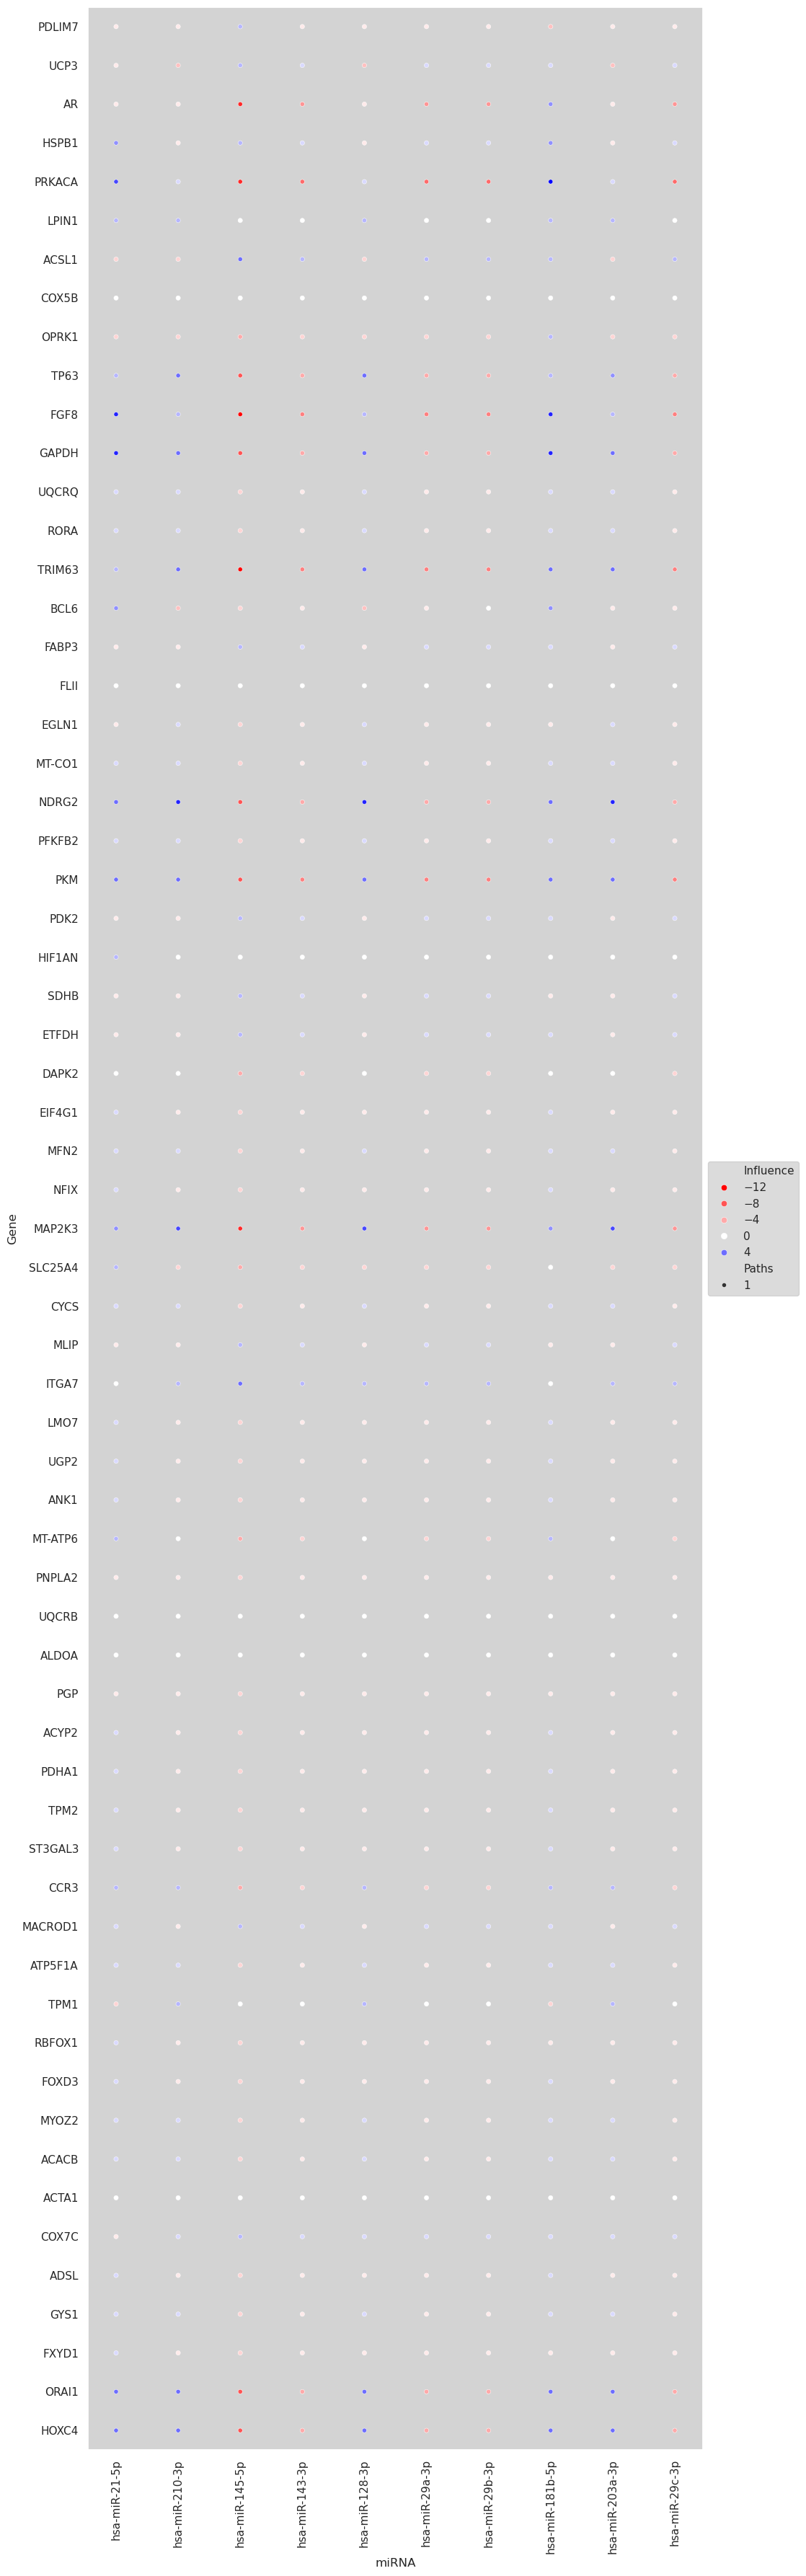

In [65]:
plot_dotplot(int_influence_muscle_df.iloc[:, : 10],gene_scale=0.7, mirna_scale=1 )

But there are genes on different stages that we may want a different effect.
Therefore, we can see the curve that the gene has.

In [79]:
theshold = 0.5
up_regulated = int_influence_muscle_df[
    (int_influence_muscle_df['ym'] > theshold) | 
    (int_influence_muscle_df['mo'] > theshold) | 
    (int_influence_muscle_df['yo'] > theshold)].copy()


In [80]:

# Add the 'sum' column
up_regulated['sum'] = up_regulated[['yo', 'ym', 'mo']].sum(axis=1)

up_regulated=up_regulated.sort_values(by='sum')
up_regulated.drop(columns=['sum'], inplace=True)
up_regulated[['yo','ym','mo']]

,yo,ym,mo
ALDOA,0.512077,0.000000,0.000000
GYS1,0.563409,0.000000,0.000000
MT-ATP6,0.577338,0.000000,0.000000
ORAI1,0.680614,0.000000,0.000000
CYCS,0.540560,0.000000,0.325282
COX7C,0.559328,0.000000,0.329616
FABP3,0.562548,0.480724,0.000000
GAPDH,1.036054,0.642676,0.000000
FGF8,3.214747,0.000000,0.000000


genes 9
mirnas 15


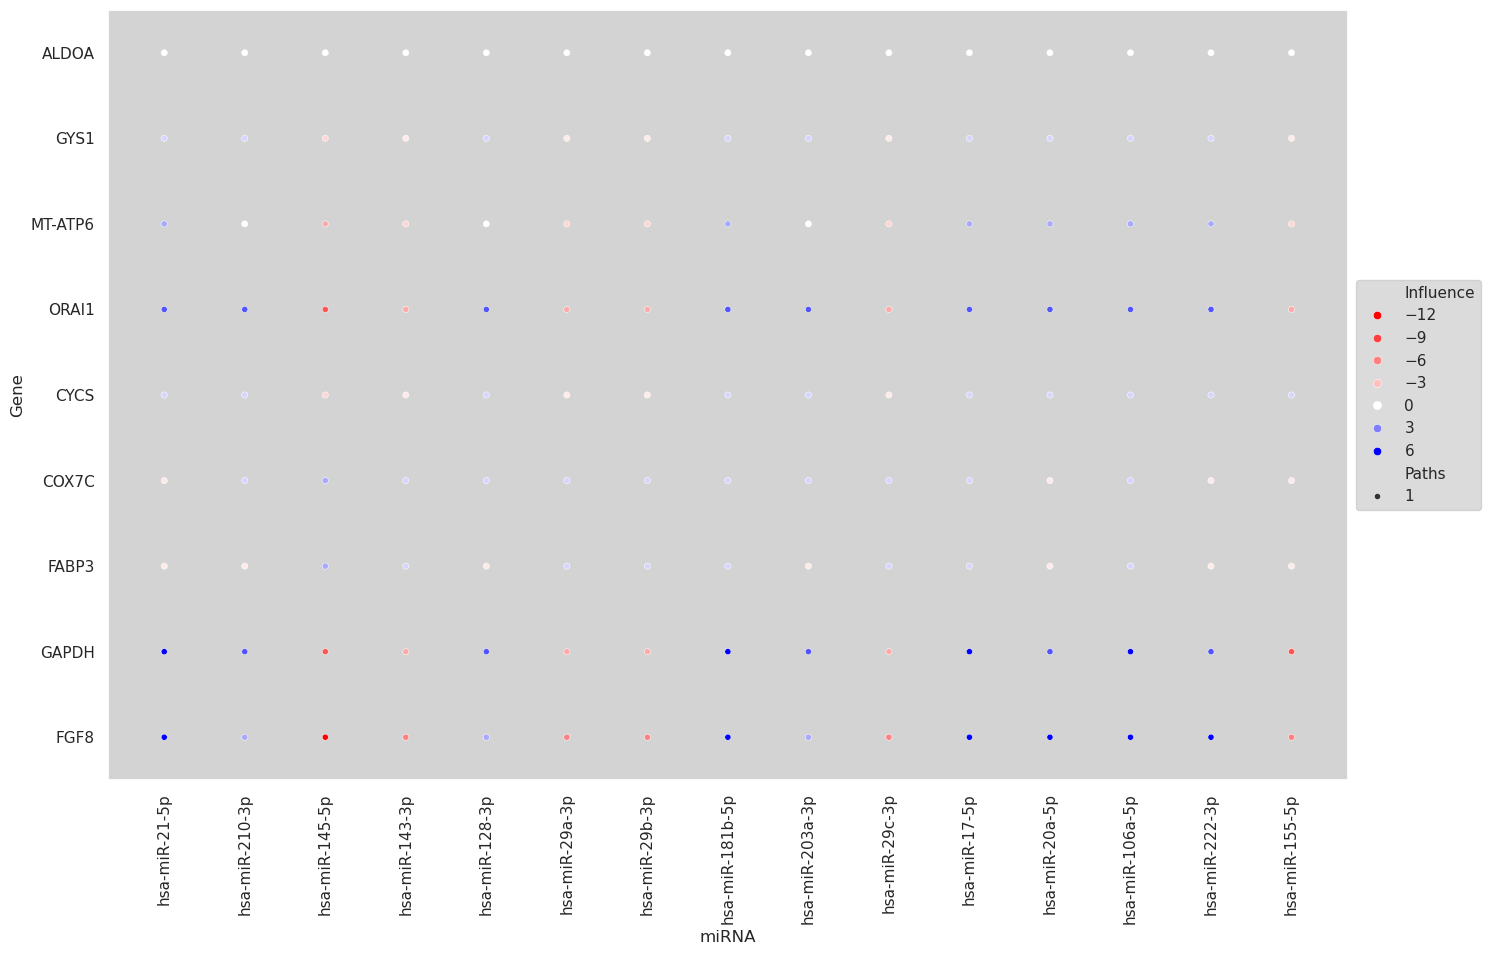

In [78]:
plot_dotplot(up_regulated.iloc[:, : 15],gene_scale=0.7, mirna_scale=1 )

In [ ]:
theshold = -2
down_regulated = int_influence_muscle_df[
    (int_influence_muscle_df['ym'] < theshold) 
    | (int_influence_muscle_df['mo'] < theshold) 
    | (int_influence_muscle_df['yo'] < theshold)
]


In [73]:
down_regulated['sum']=down_regulated['yo']+down_regulated['ym']+down_regulated['mo']
down_regulated=down_regulated.sort_values(by='sum')
down_regulated.drop(columns=['sum'], inplace=True)
down_regulated[['yo','ym','mo']]

,yo,ym,mo
FOXD3,-5.159955,-4.919748,0.000000
PNPLA2,-3.910201,0.000000,-5.557912
OPRK1,-3.216436,0.000000,-5.243079
CCR3,-4.422275,0.000000,-3.278089
HOXC4,-2.700432,0.000000,-3.560292
HIF1AN,-2.185676,0.000000,0.000000


genes 6
mirnas 15


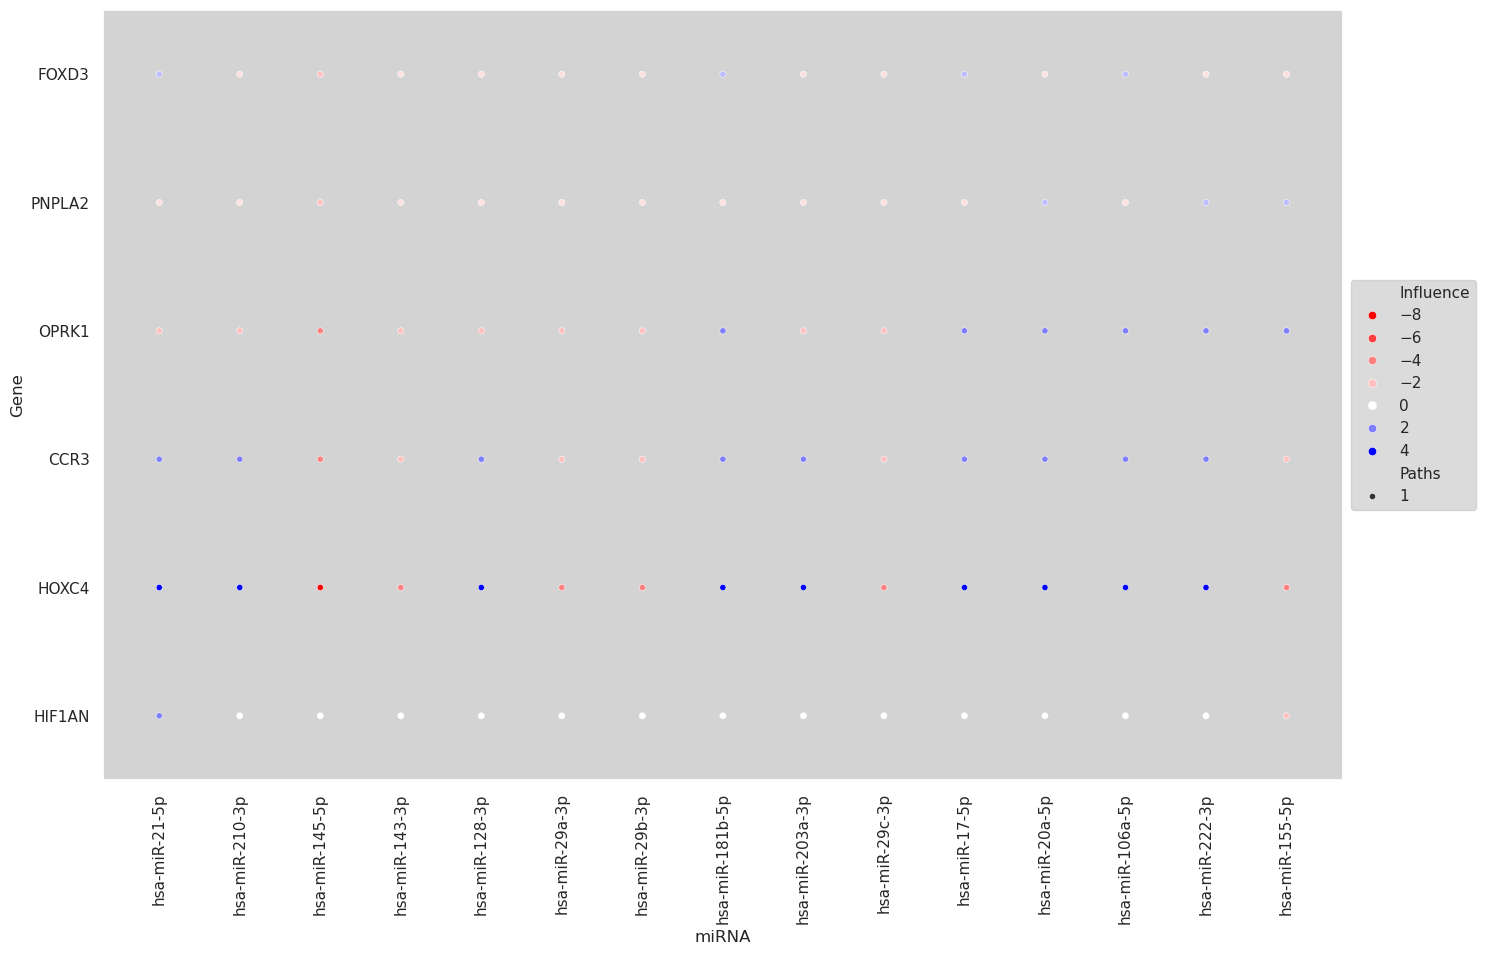

In [74]:
plot_dotplot(down_regulated.iloc[:, : 15],gene_scale=0.7, mirna_scale=1 )